# MIBCI-QCNNs: Implementation

This notebook automates the simulation and synthesis of the EEGNet-based model HLS design. This design is based on the files with the format `MIBCI-QCNN-X-template.txt` saved in the root directory of the repo. These are the parametrized templates that can be read from Python and then written into a `.cpp` (or `.h` if it's the header file), forming the following files:

- `MIBCI-QCNN.cpp`
- `MIBCI-QCNN.h`
- `MIBCI-QCNN-tb.cpp`

The first one, `MIBCI-QCNN.cpp`  is the file with the algorithmic description of the hardware to synthesize with HLS and then to implement in the FPGA. After the declaration of the activation functions, LeakyReLU and Softmax, there is the top function, MIBCI_QCNN in which the C++ implementation of the model is contained.

The header file, `MIBCI-QCNN.h`, contains the parameters of the dataset (time window, downsampling, number of classes, number of channels, sampling frequency...), the architecture parameters (kernels' sizes, number of filters, LReLU alphas...) and the fixed-point datatype description, which in this case is <16,8>, since it showed the best balance in the number of bits and the accuracy drop.

Finally, the test bench `MIBCI-QCNN-tb.cpp`. It is created to load both the model parameters and the input samples from `.npy` files and validate the model implemented in C++ for the entire dataset. As outputs, it writes a `y_hls_16_8.txt` for each fold, containing the model's output of the validation set of that fold.

## Prepare the model to be implemented

Before running the HLS simualtion, the folder of each model's fold must have an `npyparams` folder containing its pararmeters and another folder called `valdiationDS` with the validation set of the fold, i.e. the inputs (`X.npy`) splitted per index, `X_i.npy` (since only one sample can be read from C++ at the same time). All of this is automated in the [`createnpys.py` `utils` file](utils/createnpys.py).

In [1]:
from utils.createnpys import createnpys

In this case we are going to validate and synthesize the global model trained with the [`training.ipynb`](training.ipynb) notebook, that it's stored in the `global_model` folder.

> It needs to load the model to read its parameters. If you have another process using the GPU (if you have one) it will probably raise an error saying CUDA run out of memory.

In [3]:
createnpys('global_model/')

PROCESSING FOLD 1/5
0.6689342403628118
PROCESSING FOLD 2/5
0.6587301587301587
PROCESSING FOLD 3/5
0.6901927437641724
PROCESSING FOLD 4/5
0.6252834467120182
PROCESSING FOLD 5/5
0.6040249433106576


## HLS C simulation of the model

Since fixed-point datatypes are used to represent the model inputs, internal values, feature maps, parameters and outputs, it is expected to have an accuracy drop between the model implemented in Keras and its HLS version. To check the output of all the dataset must be acquired using HLS, carefully choosing the model for each sample, since we only want to acquire the validation accuracy.

This process is launched using the `launch_csim` function in the [`utils/hls_tools.py`](utils/hls_tools.py) file. It writes the `MIBCI-QCNN.cpp`, `MIBCI-QCNN.h`, and `MIBCI-QCNN-tb.cpp` files with the selected dataset parameters and also the `csim-launcher-template.txt` that is the TCL file that sets up the HLS project, selecting the `xc7z010-clg400-1` part, adding the source and testbench files and launching the HLS C simulation.

> This HLS simulation is a long process. It depends on the hardware of your computer, but it usall takes around 2 or 3 hours. If the nonpararllel version is used (see the second Warning below), it can multiply the time five times.

<div class="alert alert-block alert-warning">
<b>Warning!</b> This function must be called from a Vivado HLS-enabled bash, which can be activated using the command:
<code>
source /path/to/Vivado/installation/settings64.sh
</code>
To use this function inside of a Jupyter notebook like this one, just run this command before launching the Jupyter server.
</div>



<div class="alert alert-block alert-warning">
<b>Warning!</b> To reduce the simulation time 5 process are launched in background, one for each fold. This is done with the <code>screen</code> command of Ubuntu, so to monitor their evolutions, just check the screen processes. If you aren't on a Linux computer or you don't have at least 5 kernels, you have to use the <code>launch_csim_noparallel</code> function. Just comment the next cell and uncomment the following one.
</div>

<div class="alert alert-block alert-warning">
<b>Warning!</b> The entire path mas be passed to the function, since its embedded in the C testbench.
</div>

In [13]:
from utils.hls_tools import launch_csim

launch_csim('/home/daniel/BCI/XOH21/global_model/', T=3, ds=2, Nchans=64, Nclasses=4)

In [10]:
#from utils.hls_tools import launch_csim_noparallel

#launch_csim_noparallel('/home/daniel/BCI/XOH21/global_model/', T=3, ds=2, Nchans=64, Nclasses=4)

Once the simulation is completed, the validation accuracy of the HLS results must be checked. This can be done with the `accuracy_test` function of [`utils/accuracy_test.py`](utils/accuracy_test.py).

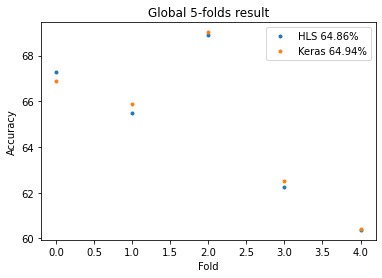

In [1]:
from utils.accuracy_test import accuracy_test

accuracy_test('global_model/')

As you can see, with <16,8> fixed-point datatypes, the validation accuracy drop is negligible.

## HLS synthesis

Once we know how good is the model performance implemented on HLS, it's time to measure its impact on the FPGA resources and its latency, that will define the inference time of the model when it will be implemented on hardware.

To automate this, [`utils/hls_tools.py`](utils/hls_tools.py) also has a function called `launch_synth` that writes `MIBCI-QCNN.cpp` and `MIBCI-QCNN.h` with the model parameters  introduced in the function, launching a synthesis using the `synth-launcher.tcl` file. As its simulation analogue, it sets an HLS project with the `xc7z010-clg400-1`, but it introduces the directives included in the `directives.tcl` file, that pipeline the inner loops of all the layers.

<div class="alert alert-block alert-warning">
<b>Warning!</b> As in the simulation, this function must be called from a Vivado HLS-enabled bash, which can be activated using the command:
<code>
source /path/to/Vivado/installation/settings64.sh
</code>
To use this function inside of a Jupyter notebook like this one, just run this command before launching the Jupyter server.
</div>

> In this case, the synthesis take a minute, more or less.


In [2]:
from utils.hls_tools import launch_synth

launch_synth(T=3, ds=2, Nchans=64, Nclasses=4)

To read the synthesis results we are using an [HLS report parser](https://github.com/tiagolascasas/Vivado-HLS-Report-Parser/blob/master/hlsparser.py) developed by Tiago Lascasas dos Santos. It creates the file `report.csv`, that contains the report's main data.

In [4]:
! python utils/hlsparser.py MIBCI-QCNN-synth/solution1/syn/report/csynth.xml MIBCI-QCNN InnerLoopsPiplined

<Element 'profile' at 0x7f4413f48680>
reports.csv not found, creating...
Report for "MIBCI-QCNN" successfully added to reports.csv


This file can be read with `pandas`

In [5]:
import pandas as pd

df = pd.read_csv('reports.csv')

df

,input,optimizations,part,target_clock,estim_clock,lat_worst,lat_avg,lat_best,FF,LUT,BRAM,DSP
0,MIBCI-QCNN,InnerLoopsPiplined,xc7z010-clg400-1,10.0,10.354,3159285,2542325,1925365,5099,9874,101,14


As you can see, the latency is in number of intervals and the resources' consumption is in absolute numbers. To get the latency in milliseconds and the resources in relative consumption to the total number of resources of each type, the following cell can be run.

In [10]:
df = df.assign(lat_worst_ms=lambda x: x.lat_worst*1e-5)
df = df.assign(lat_avg_ms=lambda x: x.lat_avg*1e-5)
df = df.assign(lat_best_ms=lambda x: x.lat_best*1e-5)
df = df.assign(FF_percent=lambda x: x.FF/17600)
df = df.assign(LUT_percent=lambda x: x.LUT/35200)
df = df.assign(BRAM_percent=lambda x: x.BRAM/120)
df = df.assign(DSP_percent=lambda x: x.DSP/80)

df.to_csv('reports.csv')

df[['target_clock', 'estim_clock',
    'lat_worst_ms', 'lat_avg_ms', 'lat_best_ms',
    'FF_percent', 'LUT_percent', 'BRAM_percent', 'DSP_percent']]


,target_clock,estim_clock,lat_worst_ms,lat_avg_ms,lat_best_ms,FF_percent,LUT_percent,BRAM_percent,DSP_percent
0,10.0,10.354,31.59285,25.42325,19.25365,0.289716,0.280511,0.841667,0.175
